In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='senti_analysis_logs')

In [34]:
columns = ['rating','date','variation','verified_reviews','feedback']
df = pd.read_table('../Datasets/alexa reviews/amazon_alexa.tsv', header=None,names=columns,skiprows=1)

In [35]:
df=df.drop("date",axis=1)
df.head(5)

,rating,variation,verified_reviews,feedback
0,5,Charcoal Fabric,Loved it!,1
1,4,Walnut Finish,"Sometimes while playing a game, you can answer...",1
2,5,Charcoal Fabric,Love my Echo!,1
3,5,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,Charcoal Fabric,Music,1


In [36]:
X,y = df['verified_reviews'].values,df['feedback'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)

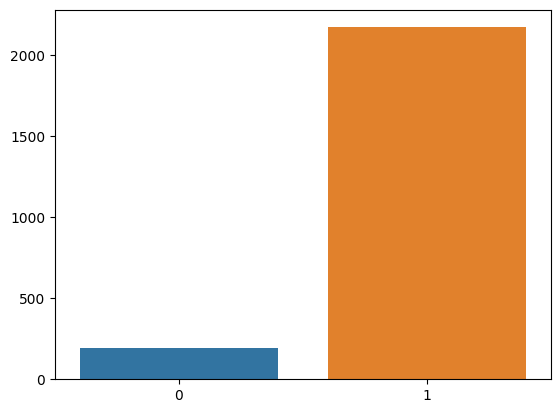

In [37]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array([1,0]),y=dd.values)
plt.show()

In [38]:

def preprocess_review(text):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # convert text to lower-case
    nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    # remove repeated characters
    # remove stopwords from final word list
    return nopunc

In [39]:
print(preprocess_review(X[0]))

loved it


In [40]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/namachu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_tweet(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # print(corpus_)
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_tweet(word)] for word in sent.lower().split() 
                                     if preprocess_tweet(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_tweet(word)] for word in sent.lower().split() 
                                    if preprocess_tweet(word) in onehot_dict.keys()])
            
    # encoded_train = [1 if label =='good' else 0 if label=='neutral' else -1 for label in y_train]  
    # encoded_test = [1 if label =='good' else 0 if label=='neutral' else -1 for label in y_val] 
    encoded_train = y_train  
    encoded_test = y_val
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [42]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/tmp/ipykernel_2249/3447531999.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


In [43]:
print(x_train)

[list([23, 109, 699, 41, 50, 312, 56, 61])
 list([1, 23, 55, 170, 109, 41, 265, 6, 700, 67, 78, 76, 46, 50, 4, 67, 78])
 list([162, 2, 1, 460, 131, 13, 325, 83, 112, 578, 291, 17, 3, 5]) ...
 list([26, 130, 134, 76, 54, 117]) list([91]) list([1])]


In [44]:
print(y_train)

[0 1 1 ... 1 1 1]


In [45]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


In [46]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [47]:
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [48]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [49]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  49, 105, 474],
        [  0,   0,   0,  ...,  53,  58, 241],
        [  0,   0,   0,  ..., 512,   8, 167],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0, 205],
        [  0,   0,   0,  ..., 234, 250,   1]])
Sample input: 
 tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])


In [50]:

class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,output_dim,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # batch_size=25
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim))
        hidden = (h0,c0)
        return hidden

In [51]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
print(len(vocab))


model = SentimentRNN(no_layers,vocab_size,output_dim,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
# model.to(device)

print(model)


1000
SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [52]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [53]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        # inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        writer.add_scalar('Loss/train', loss.item(), epoch)
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            # inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.31596472795973435 val_loss : 0.27296365400155387
train_accuracy : 90.81287044877223 val_accuracy : 87.18274111675127
Validation loss decreased (inf --> 0.272964).  Saving model ...
Epoch 2
train_loss : 0.2530038979776362 val_loss : 0.2359781617919604
train_accuracy : 91.27857747671464 val_accuracy : 88.19796954314721
Validation loss decreased (0.272964 --> 0.235978).  Saving model ...
Epoch 3
train_loss : 0.2030397487130571 val_loss : 0.21959443092346193
train_accuracy : 92.25232853513971 val_accuracy : 88.19796954314721
Validation loss decreased (0.235978 --> 0.219594).  Saving model ...
Epoch 4
train_loss : 0.16204738181005132 val_loss : 0.2191167066494624
train_accuracy : 93.81879762912786 val_accuracy : 87.56345177664974
Validation loss decreased (0.219594 --> 0.219117).  Saving model ...
Epoch 5
train_loss : 0.14027894549864403 val_loss : 0.20593429654836654
train_accuracy : 94.3268416596105 val_accuracy : 88.3248730964467
Validation loss decreased (0.219117

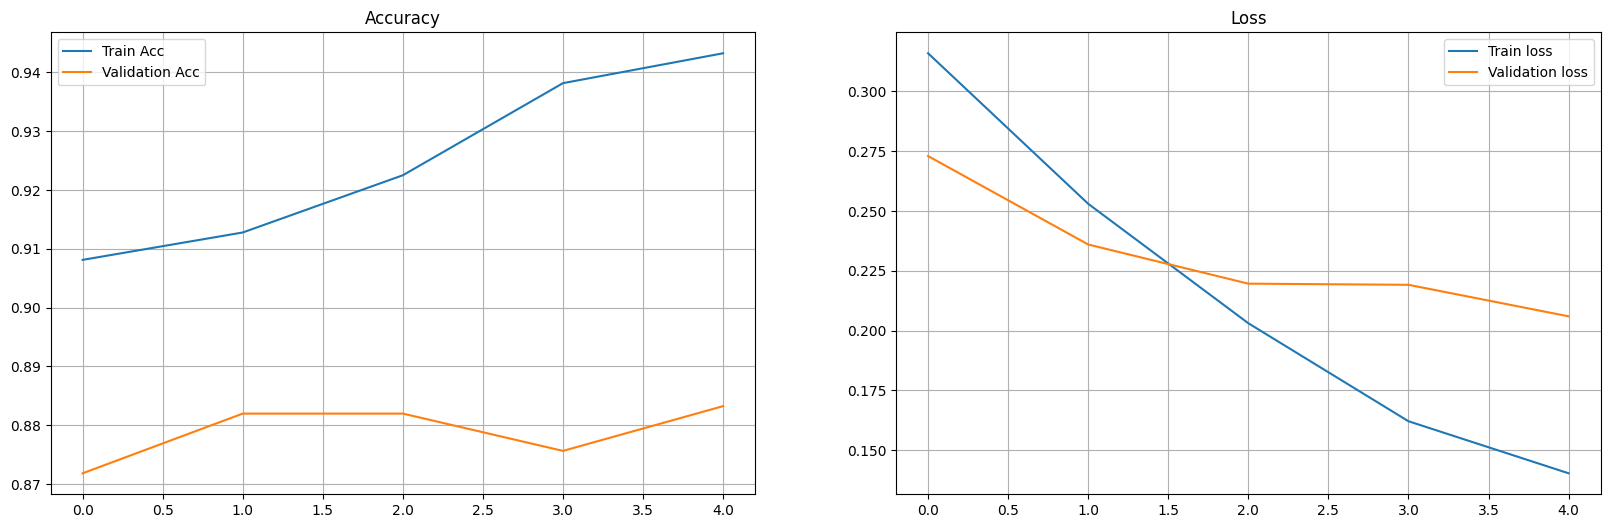

In [54]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()